# Cyber Security Threat Detection Using Machine Learning Frameworks

In [1]:
import os
os.chdir('/Users/harshithareddy/Desktop')
filename = 'output_final.csv'

In [2]:
#Importing packages
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Lambda, Input, Dense
from keras.losses import binary_crossentropy

from pandas.plotting import scatter_matrix

from tensorflow.python.framework.ops import disable_eager_execution
# disable_eager_execution()  # Remove this line to enable eager execution

import warnings
warnings.filterwarnings('ignore')

from __future__ import print_function

In [3]:
# Create DataFrame
train = pd.read_csv(filename)
train_data = train.copy()
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 entries, 0 to 998
Columns: 152 entries, 0 to 0.113
dtypes: float64(4), int64(148)
memory usage: 1.2 MB


# Data Preparation

In [4]:
array = train_data.values
X_train = array[:, 0:151]
y_train = array[:, 151]

In [5]:
# Split into a train and validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=3)
print(X_train.shape)

(799, 151)


In [6]:
#Checking train and validation sets still splits across the target evenly
print(y_train.sum())
print(y_valid.sum())

9.0
2.0


### Normalise Data

In [7]:
norm_scaler = MinMaxScaler(feature_range=(0, 1), clip=True).fit(X_train)
n_X_train = norm_scaler.transform(X_train)
print(n_X_train.shape)

(799, 151)


In [8]:
n_X_valid = norm_scaler.transform(X_valid)
print(n_X_valid.shape)

(200, 151)


# Variational Autoencoder

In [9]:
#Variational Autoencoder is used to generate 20 additional features to add to the data set
class Sampling(keras.layers.Layer):
    def call(self, input_data):
        mean, log_var = input_data
        return keras.backend.random_normal(tf.shape(log_var)) * keras.backend.exp(log_var / 2) + mean

input_size = 151
code_size = 20

input_data = Input(shape=(input_size,))
hidden_1 = Dense(75, activation='relu')(input_data)
hidden_2 = Dense(35, activation='relu')(hidden_1)

code_mean = Dense(code_size)(hidden_2)
code_log_var = Dense(code_size)(hidden_2)
code = Sampling()([code_mean, code_log_var])

var_encoder = Model(input_data, outputs=code)

decoder_inputs = Input(shape=[code_size])
hidden_3 = Dense(35, activation='relu')(decoder_inputs)
hidden_4 = Dense(75, activation='relu')(hidden_3)
output_data = Dense(input_size, activation='sigmoid')(hidden_4)

var_decoder = Model(inputs=decoder_inputs, outputs=output_data)

code_input = Input(shape=(code_size,))
reconst = var_decoder(code_input)
var_ae = Model(inputs=code_input, outputs=reconst)

In [10]:
# Custom loss function for Variational Autoencoder
def losses_func(input_data, reconst):
    code_mean = var_encoder(input_data)
    code_log_var = var_encoder(input_data)
    latent_loss = -0.5 * tf.reduce_sum(1 + code_log_var - tf.exp(code_log_var) - tf.square(code_mean), axis=-1)
    reconstruction_loss = tf.keras.losses.binary_crossentropy(input_data, reconst)
    return (tf.reduce_mean(latent_loss) / 151.) + reconstruction_loss

var_ae.compile(optimizer='adam', loss=losses_func)

# Enabling eager execution
tf.config.run_functions_eagerly(True)

# Encode input data using the encoder model
encoded_train_data = var_encoder.predict(n_X_train)
encoded_valid_data = var_encoder.predict(n_X_valid)

# Train the Variational Autoencoder with the encoded features
history = var_ae.fit(x=encoded_train_data, y=n_X_train, epochs=10, validation_data=(encoded_valid_data, n_X_valid))

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.7632 - val_loss: 0.5773
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4937 - val_loss: 0.3146
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2864 - val_loss: 0.2527
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2422 - val_loss: 0.2408
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2396 - val_loss: 0.2405
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2338 - val_loss: 0.2370
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2311 - val_loss: 0.2341
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2314 - val_loss: 0.2331
Epoch 9/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2281 - val_loss: 0.2322
Epoch 10/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2315 - val_loss: 0.2348


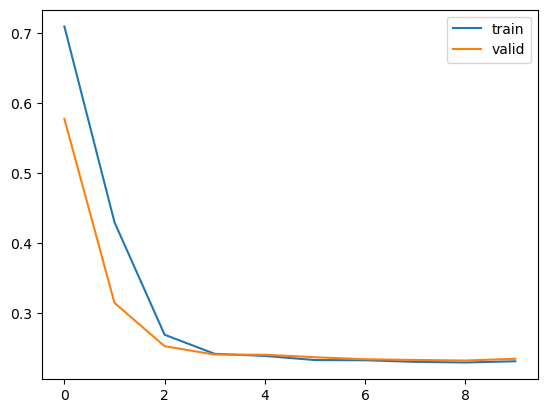

In [11]:
pyplot.plot(history.history['loss'],label = 'train')
pyplot.plot(history.history['val_loss'], label = 'valid')
pyplot.legend()
pyplot.show()  

In [12]:
#The trained variational encoder contains the reduced features from the code layer
encoded = var_encoder
gen_feat = encoded.predict(n_X_train)
print(gen_feat.shape)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(799, 20)


In [13]:
#Statistics of the generated output features
gen_featdf = pd.DataFrame(gen_feat)
gen_featdf.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000,799.000000
mean,0.051318,0.066510,0.216409,0.121266,-0.001997,0.022462,0.018569,-0.121991,0.125270,0.022344,-0.136057,0.151437,-0.120794,0.052366,-0.086945,0.123048,0.074215,0.179935,-0.098409,0.442958
std,0.878137,0.854684,0.953190,0.911102,1.031117,1.021124,0.947383,1.025155,1.040674,0.906779,1.079832,1.014471,0.947518,1.006457,1.094040,0.987997,1.035408,0.952899,1.029516,1.027205
min,-2.686767,-3.009335,-2.467596,-2.824151,-3.179710,-3.176383,-3.364993,-3.329576,-3.574659,-2.530546,-2.958592,-3.333032,-3.436123,-3.063894,-3.498911,-2.898695,-3.014067,-3.175937,-3.577396,-3.216249
25%,-0.560865,-0.504014,-0.408177,-0.503205,-0.717586,-0.665638,-0.639248,-0.797831,-0.563267,-0.573342,-0.890730,-0.531282,-0.712453,-0.603795,-0.824077,-0.520363,-0.635026,-0.430546,-0.763451,-0.277347
50%,0.055118,0.050571,0.192616,0.132629,0.040112,0.023592,-0.014753,-0.133139,0.117335,0.041308,-0.099256,0.173505,-0.110280,0.031029,-0.069485,0.096378,0.093569,0.189215,-0.123222,0.490826
75%,0.677647,0.674001,0.834747,0.708450,0.713641,0.684100,0.659322,0.519961,0.796010,0.666450,0.571146,0.849754,0.477330,0.722141,0.657561,0.788357,0.780568,0.775585,0.567749,1.164515
max,3.379782,3.128747,3.097495,2.782581,3.882154,4.564380,3.152117,3.388970,3.326988,2.696861,3.089550,3.008793,3.033540,3.379113,3.102892,3.289660,3.262309,4.210664,2.799370,3.278901


The Variational Encoder code layer, the generated features have a mean of 0 and a standard deviation of 1

In [14]:
#Normalising the generated features and creating a dataframe with new column labels
norm_scaler20 = MinMaxScaler(feature_range = (0,1), clip = True).fit(gen_feat)
n_gen_feat = norm_scaler20.transform(gen_feat)
n_gen_feat = pd.DataFrame(n_gen_feat)
new_col_headers = map(str,[160,161,162,163,164,165,166,167,168,169, 170,171,172,173,174,175,176,177,178,179])
n_gen_feat.columns= new_col_headers

In [15]:
#Adding generated features dataframe to original features dataframe
num_data = open('column_names.csv') #Column names
num_lst = []
for label in num_data:
    label = label.rstrip()
    num_lst.append(label)

n_orig_feat = pd.DataFrame(n_X_train, columns = num_lst)
n_all_feat = pd.concat([n_orig_feat,n_gen_feat],axis = 1)
print(n_all_feat.shape)

(799, 171)


# Feature Selection

### Variance Threshold Filter

In [16]:
feat_sel = VarianceThreshold()
feat_sel.fit_transform(n_all_feat)
red_feat = pd.DataFrame(feat_sel.transform(n_all_feat))
col_lst = n_all_feat.columns[feat_sel.get_support()]
print(col_lst)
print(len(col_lst))

Index(['frame.time_delta', 'frame.time_delta_displayed', 'frame.len',
       'frame.cap_len', 'frame.marked', 'frame.ignored',
       'radiotap.flags.preamble', 'radiotap.channel.type.turbo',
       'radiotap.channel.type.2ghz', 'radiotap.channel.type.5ghz',
       'radiotap.rxflags.badplcp', 'wlan.fc.ds', 'wlan.fc.frag',
       'wlan.fc.moredata', 'wlan.fc.protected', 'wlan.fc.order',
       'wlan.duration', 'wlan.ta', 'wlan.ba.control.multitid',
       'wlan_mgt.fixed.capabilities.privacy',
       'wlan_mgt.fixed.capabilities.agility',
       'wlan_mgt.fixed.capabilities.spec_man',
       'wlan_mgt.fixed.capabilities.dsss_ofdm', 'wlan_mgt.fixed.reason_code',
       'wlan_mgt.ds.current_channel', 'wlan_mgt.tim.dtim_count',
       'wlan_mgt.tim.dtim_period', 'wlan_mgt.tim.bmapctl.multicast',
       'wlan_mgt.tim.bmapctl.offset', 'wlan_mgt.rsn.gcs.type',
       'wlan_mgt.rsn.pcs.count', 'wlan_mgt.rsn.akms.count',
       'wlan_mgt.rsn.akms.type', 'wlan_mgt.rsn.capabilities.preauth',
    

In [17]:
red_feat.columns = col_lst
red_feat.shape

(799, 57)

### Kbest with Chi2 Filter

In [18]:
kbest = SelectKBest(score_func = chi2, k =30)
kbest_out = kbest.fit_transform(red_feat, y_train)
kbest_out = red_feat.columns[kbest.get_support()]
print(kbest_out)

Index(['frame.time_delta_displayed', 'frame.len', 'frame.marked',
       'frame.ignored', 'radiotap.channel.type.turbo',
       'radiotap.channel.type.2ghz', 'radiotap.channel.type.5ghz',
       'radiotap.rxflags.badplcp', 'wlan.fc.ds', 'wlan.fc.frag',
       'wlan.fc.moredata', 'wlan.fc.protected', 'wlan.duration',
       'wlan.ba.control.multitid', 'wlan_mgt.fixed.capabilities.privacy',
       'wlan_mgt.fixed.capabilities.agility',
       'wlan_mgt.fixed.capabilities.spec_man',
       'wlan_mgt.fixed.capabilities.dsss_ofdm', 'wlan_mgt.fixed.reason_code',
       'wlan_mgt.ds.current_channel', 'wlan_mgt.tim.dtim_count',
       'wlan_mgt.tim.dtim_period', 'wlan_mgt.tim.bmapctl.multicast',
       'wlan_mgt.rsn.gcs.type', 'wlan_mgt.rsn.pcs.count',
       'wlan_mgt.rsn.akms.count', 'wlan_mgt.rsn.akms.type',
       'wlan_mgt.rsn.capabilities.preauth', 'wlan.qos.eosp', 'wlan.qos.ack'],
      dtype='object')


In [19]:
red_feat2 = pd.DataFrame(kbest.transform(red_feat))
red_feat2.columns = kbest_out
red_feat2.shape

(799, 30)

### Kbest with MI Filter

In [20]:
kbest_mi = SelectKBest(score_func = mutual_info_classif, k = 15)
kbest_mi_out = kbest_mi.fit_transform(red_feat2 , y_train)
kbest_mi_out = red_feat2.columns[kbest_mi.get_support()]
print(kbest_mi_out)

Index(['frame.marked', 'frame.ignored', 'wlan.fc.ds', 'wlan.duration',
       'wlan.ba.control.multitid', 'wlan_mgt.fixed.capabilities.privacy',
       'wlan_mgt.fixed.capabilities.agility',
       'wlan_mgt.fixed.capabilities.dsss_ofdm', 'wlan_mgt.fixed.reason_code',
       'wlan_mgt.ds.current_channel', 'wlan_mgt.tim.dtim_count',
       'wlan_mgt.tim.bmapctl.multicast', 'wlan_mgt.rsn.gcs.type',
       'wlan_mgt.rsn.akms.type', 'wlan.qos.eosp'],
      dtype='object')


In [21]:
X_train_final = pd.DataFrame(kbest_mi.transform(red_feat2))
X_train_final.columns = kbest_mi_out
X_train_final.shape

(799, 15)

In [22]:
def pairwise_corr(df, threshold = 0.9):
    
    matrix = df.corr()
    mask = np.triu(np.ones_like(matrix,dtype = bool))
    reduced_matrix = matrix.mask(mask)
    col_to_drop = [col for col in reduced_matrix.columns if any (reduced_matrix[col] > threshold)]
    return col_to_drop

corr_columns = pairwise_corr(X_train_final, 0.95)
X_train_corr = X_train_final.drop(corr_columns, axis = 1)
print(X_train_corr.shape)

(799, 9)


In [23]:
#print columns
print(corr_columns)

['frame.marked', 'wlan_mgt.fixed.capabilities.privacy', 'wlan_mgt.fixed.capabilities.dsss_ofdm', 'wlan_mgt.fixed.reason_code', 'wlan_mgt.ds.current_channel', 'wlan_mgt.rsn.gcs.type']


# Selecting Algorithms

### Exploration of Possible Algorithms

In [24]:
#Comparing algorithms
array = X_train_final.values
X = array[ : , 0:15]
Y = y_train

#Model preparation
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('NB', GaussianNB()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('ET', ExtraTreesClassifier(random_state = 3)))
models.append(('LSVC', LinearSVC(random_state = 3)))
#Evaluating each model 
results = []
names = []
scoring = 'accuracy'
for name, model in models:
  kfold = KFold(n_splits=10, random_state=3,shuffle=True)
  cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.988734 (0.008752)
LDA: 0.978734 (0.032133)
NB: 0.817326 (0.047006)
KNN: 0.988734 (0.008752)
ET: 0.996250 (0.005728)
LSVC: 0.988734 (0.008752)


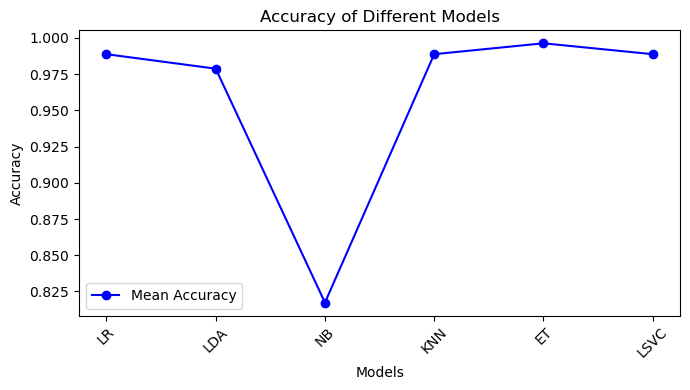

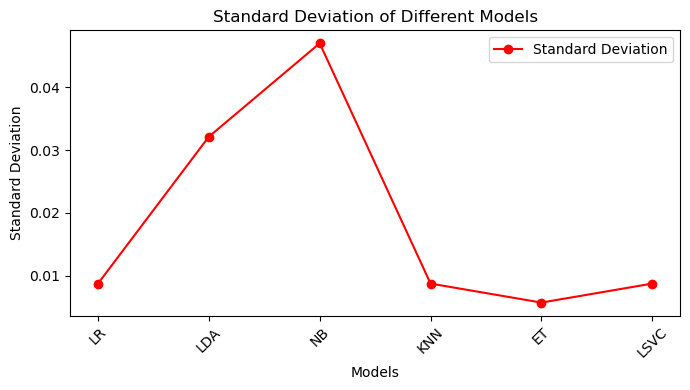

In [25]:
# Plotting cv_results.mean()
pyplot.figure(figsize=(7, 4))
pyplot.plot(names, [cv_results.mean() for cv_results in results], marker='o', linestyle='-', color='b', label='Mean Accuracy')
pyplot.title('Accuracy of Different Models')
pyplot.xlabel('Models')
pyplot.ylabel('Accuracy')
pyplot.xticks(rotation=45)
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

# Plotting cv_results.std()
pyplot.figure(figsize=(7, 4))
pyplot.plot(names, [cv_results.std() for cv_results in results], marker='o', linestyle='-', color='r', label='Standard Deviation')
pyplot.title('Standard Deviation of Different Models')
pyplot.xlabel('Models')
pyplot.ylabel('Standard Deviation')
pyplot.xticks(rotation=45)
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

**Notes on results:**

LR - performs well and trains quickly, assuming linearity  ***FURTHER TUNING DONE BELOW***

LDA/QDA - trains quickly due to dimensionality reduction, performs moderately  ***FURTHER TUNING DONE BELOW***

KNN - performs well but takes more time to run  ***FURTHER TUNING DONE BELOW***

Extra trees - performs too well, likely overfitting, wont peform well on test data. 

NB - simple and performs well, good candidate algorithm  ***FURTHER TUNING DONE BELOW***

Linear SVC - perfoms well since it uses gradient descent and a linear function to reduce the training time, quicker than ET ***FURTHER TUNING DONE BELOW***

## Hyperparameter Tuning

### Logistic Regression Tuning

In [26]:
# Parameters available for LR are: penalty, C, solver
param_grid_lr = [
    {'solver':['lbfgs','liblinear','sag','saga','newton-cg'],'C': [0.01,0.05,0.08,0.1,0.3,0.5,0.8]},
    {'penalty': ['l1'],'solver':['liblinear','saga'],'C': [0.01,0.05,0.08,0.1,0.3,0.5,0.8]},
    {'penalty': ['none'],'solver':['lbfgs','sag','saga','newton-cg'],'C': [0.01,0.05,0.08,0.1,0.3,0.5,0.8]},
]

lr_model = LogisticRegression()
lr_search = RandomizedSearchCV(lr_model, param_grid_lr ,random_state = 2, cv = 5)
lr_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions=[{'C': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5,
                                               0.8],
                                         'solver': ['lbfgs', 'liblinear', 'sag',
                                                    'saga', 'newton-cg']},
                                        {'C': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5,
                                               0.8],
                                         'penalty': ['l1'],
                                         'solver': ['liblinear', 'saga']},
                                        {'C': [0.01, 0.05, 0.08, 0.1, 0.3, 0.5,
                                               0.8],
                                         'penalty': ['none'],
                                         'solver': ['lbfgs', 'sag', 'saga',
                                                    'newton-cg']}],
                   random_state=2)

#### Best results for logistic regression:

In [27]:
lr_search.best_params_

{'solver': 'newton-cg', 'C': 0.5}

In [28]:
lr_search.best_estimator_

LogisticRegression(C=0.5, solver='newton-cg')

In [29]:
lr_search.best_score_

0.98874213836478

The above score is an improvement on the initial exploration of models above

### NB Tuning

In [30]:
param_grid_nb = [
    {'var_smoothing': [1e-10,1e-9,1e-7,1e-5]},
    ]

nb_model = GaussianNB()

nb_search = RandomizedSearchCV(nb_model,param_grid_nb,random_state =3, cv=5)
nb_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=GaussianNB(),
                   param_distributions=[{'var_smoothing': [1e-10, 1e-09, 1e-07,
                                                           1e-05]}],
                   random_state=3)

In [31]:
nb_search.best_params_

{'var_smoothing': 1e-05}

In [32]:
nb_search.best_estimator_

GaussianNB(var_smoothing=1e-05)

In [33]:
nb_search.best_score_

0.824685534591195

The above score is small improvement on the untuned model

### LSVC Tuning

In [34]:
param_grid_lsvc = [
    {'penalty': ['l1','l2'], 
     'loss': ['sqaured_hinge','hinge'], 
     'C':[0.1,0.3,0.5,0.8,1.0,1.2,1.5,2.0]},
    ]

lsvc_model = LinearSVC(random_state = 3)

lsvc_search = RandomizedSearchCV(lsvc_model,param_grid_lsvc,random_state =3, cv=5)
lsvc_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=LinearSVC(random_state=3),
                   param_distributions=[{'C': [0.1, 0.3, 0.5, 0.8, 1.0, 1.2,
                                               1.5, 2.0],
                                         'loss': ['sqaured_hinge', 'hinge'],
                                         'penalty': ['l1', 'l2']}],
                   random_state=3)

In [35]:
lsvc_search.best_params_

{'penalty': 'l2', 'loss': 'hinge', 'C': 1.5}

In [36]:
lsvc_search.best_estimator_

LinearSVC(C=1.5, loss='hinge', random_state=3)

In [37]:
lsvc_search.best_score_

0.98874213836478

The above score is small improvement on the untuned model

### KNN Tuning

In [38]:
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'p': [1, 2]  # for Manhattan and Euclidean distance
}

# Initializing the KNN model
knn_model = KNeighborsClassifier()

knn_search = RandomizedSearchCV(knn_model, param_distributions=param_grid_knn, n_iter=20, random_state=2, cv=5)
knn_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=20,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'n_neighbors': [3, 5, 7, 9, 11],
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=2)

In [39]:
knn_search.best_params_

{'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'algorithm': 'ball_tree'}

In [40]:
knn_search.best_estimator_

KNeighborsClassifier(algorithm='ball_tree', p=1, weights='distance')

In [41]:
knn_search.best_score_

0.9925

The above score is small improvement on the untuned model

### LDA Tuning

In [42]:
param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': ['auto', None],
    'tol': [1e-4, 1e-3, 1e-2]
}

# Initializing the LDA model
lda_model = LinearDiscriminantAnalysis()

lda_search = RandomizedSearchCV(lda_model, param_distributions=param_grid_lda, n_iter=20, random_state=2, cv=5)
lda_search.fit(X_train_final, y_train)

RandomizedSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(), n_iter=20,
                   param_distributions={'shrinkage': ['auto', None],
                                        'solver': ['svd', 'lsqr', 'eigen'],
                                        'tol': [0.0001, 0.001, 0.01]},
                   random_state=2)

In [43]:
lda_search.best_params_

{'tol': 0.0001, 'solver': 'lsqr', 'shrinkage': 'auto'}

In [44]:
lda_search.best_estimator_

LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr')

In [45]:
lda_search.best_score_

0.954882075471698

The above score has not improved from the untuned model results 

## 5 Models Tuning Summary

In [46]:
# Comparing 5 models with tuned parameters

array = X_train_final.values
X = array[ : , 0:15]
Y = y_train

# Preparing models with best parameters output
models3 = []
models3.append(('LR', lr_search.best_estimator_))
models3.append(('NB', nb_search.best_estimator_))
models3.append(('LSVC', lsvc_search.best_estimator_))
models3.append(('KNN', knn_search.best_estimator_))
models3.append(('LDA', lda_search.best_estimator_))

# Evaluating each model after tuning
results = []
names = []
scoring = 'accuracy'
for name, model in models3:
  kfold = KFold(n_splits=10, random_state=3,shuffle=True)
  cv_results = cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.988734 (0.008752)
NB: 0.823576 (0.045079)
LSVC: 0.988734 (0.008752)
KNN: 0.992484 (0.006137)
LDA: 0.961234 (0.041617)
